In [ ]:
import os
import random
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import preprocessing 
import tensorflow.keras.layers as tfkl

from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

In [ ]:
tf.config.list_physical_devices('GPU')

# Parameters

In [ ]:
dataset_dir = 'data'

In [ ]:
# Random seed for reproducibility
SEED = 42
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.compat.v1.set_random_seed(SEED)

In [ ]:
EPOCHS = 40
LEARNING_RATE = 0.0001
BATCH_SIZE = 8
VALIDATION_SPLIT = 0.2

IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 256, 256, 3

# Dataset analysis

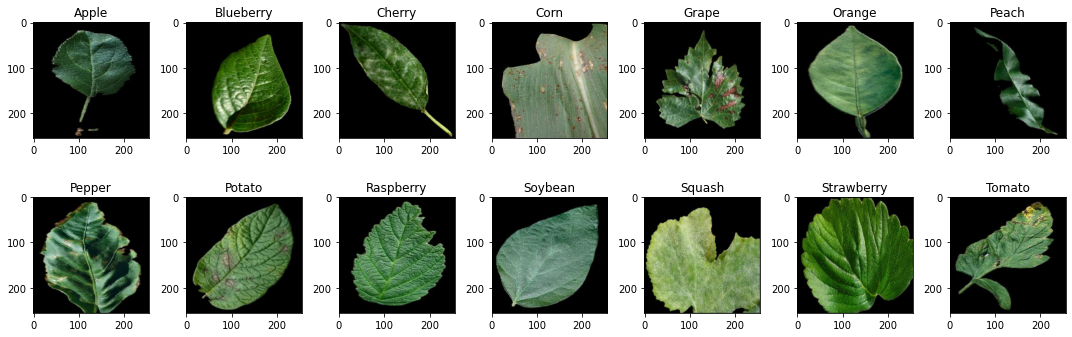

In [ ]:
# Plot example images from dataset
labels = [
    'Apple',
    'Blueberry',
    'Cherry',
    'Corn',
    'Grape',
    'Orange',
    'Peach',
    'Pepper',
    'Potato',
    'Raspberry',
    'Soybean',
    'Squash',
    'Strawberry',
    'Tomato',
]

num_row = len(labels)//7
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(15,5))
for i in range(len(labels)):
    class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[np.random.randint(len(class_imgs))]  # pick random image
    img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

Total (train/val): 17728 (~14182/~3546)


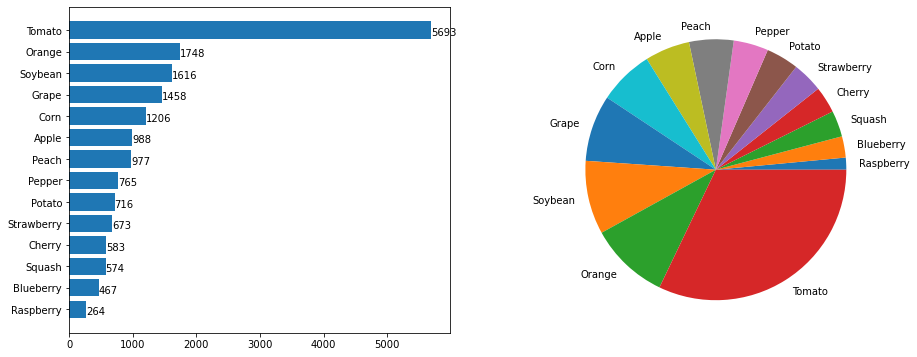

In [ ]:
# Evaluation of class balance (accuracy metric could be misleading for imbalanced classes)
N = {}
for dirpath, dirnames, filenames in os.walk(dataset_dir):
    s = dirpath.split('\\')
    if len(s) > 1:
        N[s[-1]] = len(filenames)
n = sum(N.values())
print(f'Total (train/val): {n} (~{n*(1-VALIDATION_SPLIT):.0f}/~{n*VALIDATION_SPLIT:.0f})')

#Make plots representing the class imbalance
fig, ax = plt.subplots(1,2, figsize=(15,6))
x = sorted(list(N.keys()), key=lambda x:N.get(x))
y = sorted(N.values())
ax[0].barh(x, y)
for i, v in enumerate(y):
    ax[0].text(v, i-.25, str(v))
ax[1].pie(y, labels=x)
plt.show()


The dataset is characterized  by a strong class imbalance.

# Data loading & Augmentation

In [ ]:
# Define data generator and augmentation steps
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=45, 
    brightness_range=(0.9, 1.1),
    zoom_range=0.2,
    channel_shift_range=0.01,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,  
    validation_split=VALIDATION_SPLIT, 
    dtype=tf.float32
)

In [ ]:
# Define train and validation generators for model fitting

train_generator = data_generator.flow_from_directory(
    directory=dataset_dir, 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    classes=labels,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset="training",
    seed=SEED
)

validation_generator = data_generator.flow_from_directory(  
    directory=dataset_dir, 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    classes=labels,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset="validation",
    seed=SEED
)

Found 14189 images belonging to 14 classes.
Found 3539 images belonging to 14 classes.


# Model

In [ ]:
# Define model layers

dropout_rate = 0.1

inputs = tfkl.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
conv1 = tfkl.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(inputs)
norm1 = tfkl.BatchNormalization()(conv1)
pool1 = tfkl.MaxPooling2D(pool_size=(2,2))(norm1)  

conv2 = tfkl.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(pool1)
norm2 = tfkl.BatchNormalization()(conv2)
pool2 = tfkl.MaxPooling2D(pool_size=(2,2))(norm2)

conv3 = tfkl.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(pool2)
norm3 = tfkl.BatchNormalization()(conv3)
pool3 = tfkl.MaxPooling2D(pool_size=(2,2))(norm3)

conv4 = tfkl.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(pool3)
norm4 = tfkl.BatchNormalization()(conv4)
pool4 = tfkl.MaxPooling2D(pool_size=(2,2))(norm4)

conv5 = tfkl.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(pool4)
norm5 = tfkl.BatchNormalization()(conv5)
pool5 = tfkl.MaxPooling2D(pool_size=(2,2))(norm5)

flatten = tfkl.Flatten()(pool5)    

fc1 = tfkl.Dense(units=128, activation='relu')(flatten)  
drop1 = tf.keras.layers.Dropout(dropout_rate)(fc1)

fc2 = tfkl.Dense(units=64, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(dropout_rate)(fc2)

outputs = tfkl.Dense(units=len(labels), activation='softmax')(drop2)

In [ ]:
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='model')
#Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              metrics='accuracy')

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0     

In [ ]:
best_model_path = "SubmissionModel/leaf_classification" 
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    best_model_path, 
    save_best_only=True,
    verbose=1)

early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-12,
    patience=4, 
    restore_best_weights=True,
    verbose=1)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    min_delta=1e-10,
    patience=3,
    factor=0.2,
    verbose=1)

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    checkpointer, 
    lr_reducer,
    early_stopper,
]

In [ ]:
history = model.fit(
    x=train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    workers=4, use_multiprocessing=True,
    verbose=2
)

Epoch 1/40
1774/1774 - 274s - loss: 1.5034 - accuracy: 0.5390 - val_loss: 1.2900 - val_accuracy: 0.5973

Epoch 00001: val_loss improved from inf to 1.29005, saving model to SubmissionModel\leaf_classification_adv_regul.h5
Epoch 2/40
1774/1774 - 266s - loss: 1.0217 - accuracy: 0.6869 - val_loss: 1.2260 - val_accuracy: 0.6584

Epoch 00002: val_loss improved from 1.29005 to 1.22601, saving model to SubmissionModel\leaf_classification_adv_regul.h5
Epoch 3/40
1774/1774 - 285s - loss: 0.8054 - accuracy: 0.7526 - val_loss: 1.1820 - val_accuracy: 0.6575

Epoch 00003: val_loss improved from 1.22601 to 1.18199, saving model to SubmissionModel\leaf_classification_adv_regul.h5
Epoch 4/40
1774/1774 - 277s - loss: 0.6569 - accuracy: 0.7947 - val_loss: 0.7411 - val_accuracy: 0.7737

Epoch 00004: val_loss improved from 1.18199 to 0.74107, saving model to SubmissionModel\leaf_classification_adv_regul.h5
Epoch 5/40
1774/1774 - 272s - loss: 0.5561 - accuracy: 0.8261 - val_loss: 0.8212 - val_accuracy: 0.7

# Evaluation

In [ ]:
best_model = tf.keras.models.load_model(best_model_path)

In [ ]:
y_pred = []
y_true = []
for i in tqdm(range(len(validation_generator))):
    data, target = validation_generator[i]
    y_pred.extend(list(best_model.predict(data).argmax(axis=1)))  # predictions as label indices, correct
    y_true.extend(list(target.argmax(axis=1)))

100%|████████████████████████████████████████████████████████████████████████████████| 443/443 [01:10<00:00,  6.29it/s]


In [ ]:
confusion_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()

In [ ]:
# Compute accuracy
np.sum(confusion_matrix * np.eye(len(confusion_matrix))) / np.sum(confusion_matrix)

0.9480079118395027

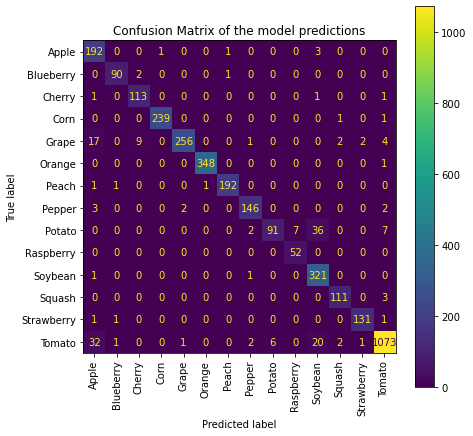

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
disp = ConfusionMatrixDisplay(confusion_matrix, display_labels=labels)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='d')
plt.title("Confusion Matrix of the model predictions")
plt.show()

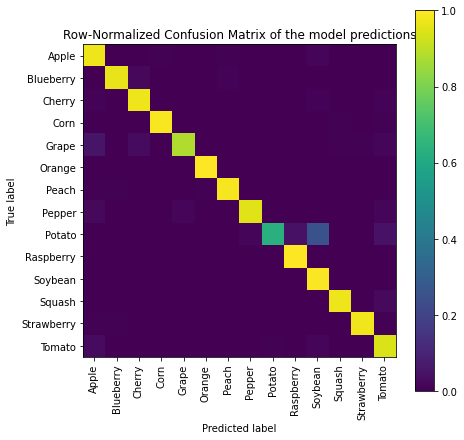

In [ ]:
confusion_matrix_norm = confusion_matrix / confusion_matrix.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(7,7))
disp = ConfusionMatrixDisplay(confusion_matrix_norm, display_labels=labels)
disp.plot(ax=ax, xticks_rotation='vertical', include_values=False)
plt.title("Row-Normalized Confusion Matrix of the model predictions")
plt.show()